In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from generate_data import generate_univ_sim_and_obs

from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData

## Univariate-output simple example

In this example, we use synthetic data generated as follows.

Simulation data: $y_{sim} = 2.5 \cos(10 t)$

Observed data: $y_{obs} = 2.5 \cos(10 t) + \epsilon$

where $\epsilon \sim N(0, \sigma^2_n)$.

In this case, $t$ is a univariate input variable, and both simulation and observed outputs
vary smoothly with $t$.
In this example, we generate the $t$ corresponding to $y_{obs}$, but in a real data situation,
these would be unknown and are the goal of inference.

The goal of calibration is to:

1. Capture the smooth relationship between $t$ and $y$ with a Gaussian process.
2. Infer posterior distributions over $t$ corresponding to the observed data.

First, we generate the synthetic data.

In [85]:
seed = 42   # random seed
m = 100     # number of simulated observations
n = 1       # number of observed data
sig_n = 0.1 # observation noise SD

data_dict = generate_univ_sim_and_obs(m, n, sig_n, seed)


Next, we initialize the SepiaData object which does some basic checking about whether the input data
are of the correct shapes, and infers what kind of model you're going to use based on the input data.

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 1, obs y dimension 1
n  =     1 (number of observed data)
m  =   100 (number of simulated data)
p  =     1 (number of inputs)
q  =     1 (number of additional simulation inputs to calibrate)
pu =     1 (univariate response dimension)


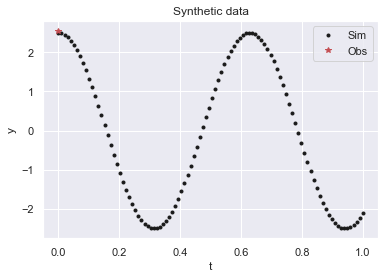

In [86]:
data = SepiaData(t_sim=data_dict['t_sim'], y_sim=data_dict['y_sim'], y_obs=data_dict['y_obs'])
print(data)

plt.plot(data.sim_data.t, data.sim_data.y, 'k.')
plt.plot(data_dict['t_obs'], data.obs_data.y, 'r*')
plt.title('Synthetic data')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['Sim', 'Obs'])
plt.show()

Standardization of data is important for default priors in the model to work well.

In this case, $t$ is already in $[0, 1]$.
If not, we would want to call `data.standardize_xt()`.

We do standardize the $y$ values:

In [87]:
data.standardize_y()

Next, we set up the model object; a lot of precalculation of important model components is done here.

In [94]:
model = setup_model(data)

We will use all the default priors and settings to do MCMC.

We first call `model.tune_step_sizes(50, 20)` which uses 50 samples over 20 different step sizes
to find one with a good acceptance rate.

We then draw 1000 MCMC samples.

In [95]:
model.tune_step_sizes(50, 20)
model.do_mcmc(1000)

MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 148.32it/s]


Here is a basic visualization of the MCMC results: histograms of the MCMC samples.

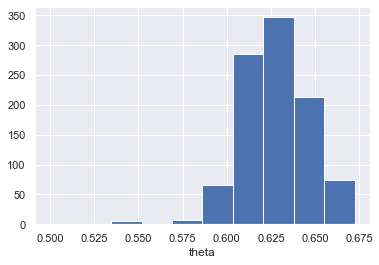

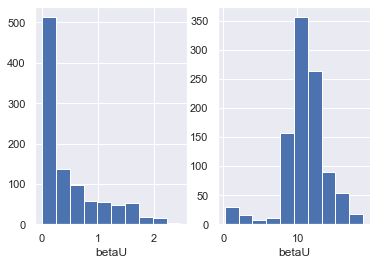

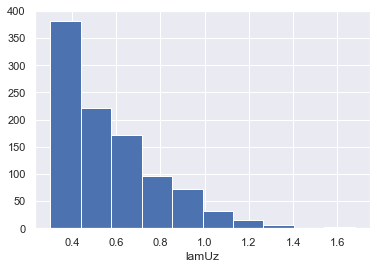

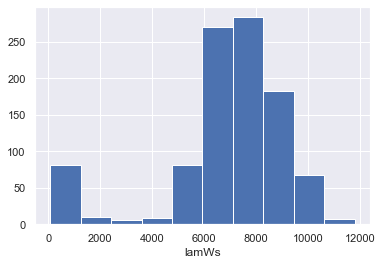

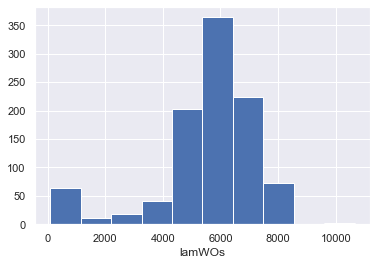

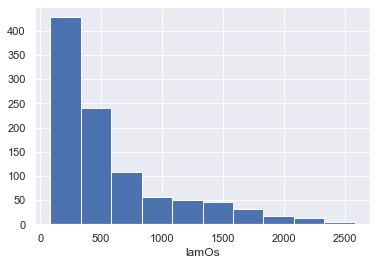

In [96]:
# Extract MCMC samples into dictionary with parameter names
samples_dict = {p.name: p.mcmc_to_array() for p in model.params.mcmcList}

for i, k in enumerate(samples_dict.keys()):
    param_shape = samples_dict[k].shape[1]
    if param_shape >= 5:
        ncol = 5
        nrow = int(np.ceil(param_shape / ncol))
    else:
        ncol = param_shape
        nrow = 1
    plt.figure(i)
    for j in range(param_shape):
        plt.subplot(nrow, ncol, j + 1)
        plt.hist(samples_dict[k][:, j])
        plt.xlabel(k)
    plt.show()

The parameters `betaU` and `lamUz` correspond to the Gaussian process lengthscale and marginal variance,
while `lamWs`, `lamWOs`, and `lamOs` are nugget and observation noise precisions.

Most easy to interpret is `theta`, which is the posterior distribution over the $t$ that generated $y_{obs}$.
If we show the posterior distribution of `theta` on the original data plot as a rug plot, we see something interesting.

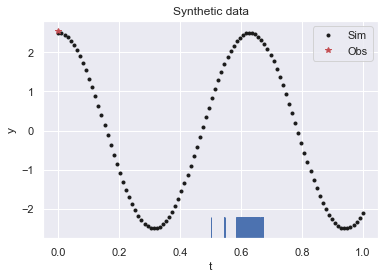

In [97]:
plt.plot(data.sim_data.t, data.sim_data.y, 'k.')
plt.plot(data_dict['t_obs'], data.obs_data.y, 'r*')
sns.rugplot(samples_dict['theta'], height=0.1)
plt.title('Synthetic data')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['Sim', 'Obs'])
plt.show()

The MCMC sampler has found a region of theta/t that is consistent with the observed $y$,
but it has not found the region that actually generated the data.

If we run the sampler longer, we would expect to find a bimodal distribution for theta.
As a shortcut, we will try changing the start value for `theta` so the chain will explore the lower region.

In [98]:
model.params.theta.set_val(0.01)
model.do_mcmc(1000)


MCMC sampling: 100%|██████████| 1000/1000 [00:06<00:00, 152.13it/s]


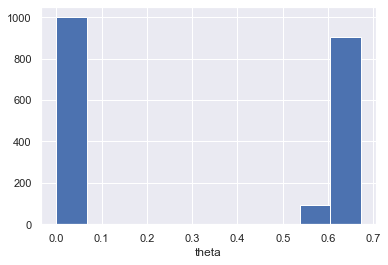

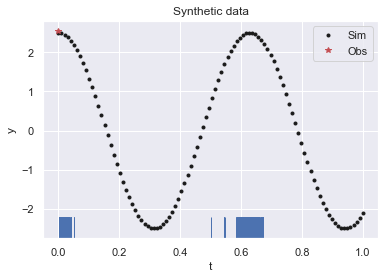

In [101]:
samples_dict = {p.name: p.mcmc_to_array() for p in model.params.mcmcList}

plt.hist(samples_dict['theta'])
plt.xlabel('theta')
plt.show()

plt.plot(data.sim_data.t, data.sim_data.y, 'k.')
plt.plot(data_dict['t_obs'], data.obs_data.y, 'r*')
sns.rugplot(samples_dict['theta'], height=0.1)
plt.title('Synthetic data')
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['Sim', 'Obs'])
plt.show()

Now we see a bimodal distribution for `theta`, where values near 0 or 0.6 both give outputs consistent with the observations.